# Recipe Ratings

**Name(s)**: (Howard Chen, Jialin Hu)

**Website Link**: (https://hc414.github.io/RecipeRatings/)

In [118]:
import pandas as pd
import numpy as np
import os

from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction

In [119]:
# TODO

## Step 2: Data Cleaning and Exploratory Data Analysis

We first filled `np.nan` values for the `'ratings'` column of the `raw_interactions` dataframe as we believe that the missingness of `ratings` is not by random. We believe that it is more likely for people who are unsatisfied to not leave a rating. We left merged the `raw_recipes` and `raw_interactions` dataframe on each recipe's id so the merged dataframe will have a row per rating for each recipe (no rows if no ratings found in `raw_interations`). We then made sure that values in `nutrition`, `tags`, `steps`, `ingredients` are stored as a list (for easier access) as well as converted values of the `submitted` and `date` columns to `datetime` objects.

In [120]:
fp = os.path.join('data', 'RAW_recipes.csv')
fp2 = os.path.join('data', 'RAW_interactions.csv')

raw_recipes = pd.read_csv(fp)

# raw_recipes = pd.read_csv('RAW_recipes.csv')
raw_interactions = pd.read_csv(fp2)
raw_interactions['rating'] = raw_interactions['rating'].replace(0, np.nan)


In [121]:
recipes_df = pd.merge(raw_recipes, raw_interactions, left_on = 'id', right_on = 'recipe_id')
recipe_avg_rating = recipes_df.groupby('id').mean()['rating']
recipes_df = recipes_df.merge(recipe_avg_rating, left_on = 'recipe_id', right_on = 'id')
recipes_df = recipes_df.rename(columns={'rating_x': 'rating','rating_y': 'recipe_avg_rating'})
recipes_df['nutrition'] = recipes_df['nutrition'].apply(lambda x: eval(x))
recipes_df['tags'] = recipes_df['tags'].apply(lambda x: eval(x))
recipes_df['steps'] = recipes_df['steps'].apply(lambda x: eval(x))
recipes_df['ingredients'] = recipes_df['ingredients'].apply(lambda x: eval(x))

recipes_df['submitted'] = recipes_df['submitted'].apply(lambda x: pd.to_datetime(x))
recipes_df['date'] = recipes_df['date'].apply(lambda x: pd.to_datetime(x))

recipes_df['calories'] = recipes_df['nutrition'].apply(lambda x: x[0])
recipes_df['total_fat'] = recipes_df['nutrition'].apply(lambda x: x[1])
recipes_df['sugar'] = recipes_df['nutrition'].apply(lambda x: x[2])
recipes_df['sodium'] = recipes_df['nutrition'].apply(lambda x: x[3])
recipes_df['protein'] = recipes_df['nutrition'].apply(lambda x: x[4])
recipes_df['sat_fat'] = recipes_df['nutrition'].apply(lambda x: x[5])
recipes_df['carbs'] = recipes_df['nutrition'].apply(lambda x: x[6])
recipes_df = recipes_df.drop(columns = ['nutrition'])

In [122]:
recipes_df


name      id  minutes  \
0               1 brownies in the world    best ever  333281       40   
1                 1 in canada chocolate chip cookies  453467       45   
2                             412 broccoli casserole  306168       40   
...                                              ...     ...      ...   
234425  cookies by design   sugar shortbread cookies  298509       20   
234426  cookies by design   sugar shortbread cookies  298509       20   
234427  cookies by design   sugar shortbread cookies  298509       20   

        contributor_id  ... sodium protein  sat_fat carbs  
0               985201  ...    3.0     3.0     19.0   6.0  
1              1848091  ...   22.0    13.0     51.0  26.0  
2                50969  ...   32.0    22.0     36.0   3.0  
...                ...  ...    ...     ...      ...   ...  
234425          506822  ...    4.0     4.0     11.0   6.0  
234426          506822  ...    4.0     4.0     11.0   6.0  
234427          506822  ...    4.0     4.0     11.0   6.0  

[234428 rows x 24 columns]

In [123]:
top_10_ingred = recipes_df['ingredients'][:10]
top_10_ingred

0    [bittersweet chocolate, unsalted butter, eggs,...
1    [white sugar, brown sugar, salt, margarine, eg...
2    [frozen broccoli cuts, cream of chicken soup, ...
                           ...                        
7    [meatloaf mixture, unsmoked bacon, goat cheese...
8    [meatloaf mixture, unsmoked bacon, goat cheese...
9    [ground beef, taco seasoning, taco shells, let...
Name: ingredients, Length: 10, dtype: object

In [124]:


ingred_list =[]
for ingred in top_10_ingred:
    each_ingred=' '.join(ingred)
    ingred_list.append(each_ingred)

ingred_list[0]

'bittersweet chocolate unsalted butter eggs granulated sugar unsweetened cocoa powder vanilla extract brewed espresso kosher salt all-purpose flour'

In [125]:
fig = px.histogram(recipes_df, x='rating', nbins=20, title='Distribution of Recipe Ratings')
fig.update_xaxes(title_text='Rating')
fig.update_yaxes(title_text='Count')
fig.show()

In [126]:
fig = px.scatter(recipes_df, x='minutes', y='rating', title='Rating vs Recipe Preparation Time',
                 labels={'minutes': 'Preparation Time in Minutes', 'rating': 'Rating'})
fig.show()

In [127]:
recipes_df.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'user_id', 'recipe_id', 'date', 'rating', 'review', 'recipe_avg_rating',
       'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'sat_fat',
       'carbs'],
      dtype='object')

In [128]:
# recipes_df['ingredients_category'] = pd.cut(recipes_df['n_ingredients'], bins=[0, 5, 10, np.inf], labels=['Low', 'Medium', 'High'])
bins = [0, 5, 10, np.inf]
labels = ['0-5', '6-10', '11+']
recipes_df['ingredients_category'] = pd.cut(recipes_df['n_ingredients'], bins=bins, labels=labels, right=False)

fig = px.box(recipes_df, x='ingredients_category', y='rating', title='Ratings vs Number of Ingredients',
             labels={'ingredients_category': 'Number of Ingredients Categories', 'rating': 'Rating'},
             notched=True, category_orders={'ingredients_category': labels})  # Optional notches

fig.show()


In [129]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

top_10_ingred = recipes_df['ingredients']


ingred_list =[]
for ingred in top_10_ingred:
    each_ingred=' '.join(ingred)
    ingred_list.append(each_ingred)


#count vector
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(ingred_list)


# pd.DataFrame(count_vec.transform(ingred_list).toarray(),
#              columns=pd.Series(count_vec.vocabulary_).sort_values().index)

tfidf_matrix = tfidf_vec.fit_transform(ingred_list)

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vec.get_feature_names_out())

avg_tfidf_scores = tfidf_df.mean().sort_values(ascending=False)

top_30_common_ingredient = avg_tfidf_scores.head(30)

common_list = top_30_common_ingredient.index.tolist()
common_list

['pepper',
 'salt',
 'sugar',
 'cheese',
 'oil',
 'butter',
 'fresh',
 'garlic',
 'ground',
 'flour',
 'powder',
 'onion',
 'milk',
 'water',
 'olive',
 'cream',
 'chicken',
 'sauce',
 'baking',
 'juice',
 'black',
 'eggs',
 'lemon',
 'red',
 'vanilla',
 'cloves',
 'white',
 'egg',
 'dried',
 'green']

In [130]:
def contains_rare_ingredient(ingredient_list):
    return all(ingredient not in common_list for ingredient in ingredient_list)

recipes_df['has_rare_ingredient'] = recipes_df['ingredients'].apply(contains_rare_ingredient)
recipes_df['has_rare_ingredient'].value_counts()

False    179963
True      54465
Name: has_rare_ingredient, dtype: int64

In [131]:
rare_recipes_df = recipes_df[['minutes','n_steps', 'n_ingredients', 'rating', 'has_rare_ingredient']]
rare_recipes_df

minutes  n_steps  n_ingredients  rating  has_rare_ingredient
0            40       10              9     4.0                False
1            45       12             11     5.0                False
2            40        6              9     5.0                False
...         ...      ...            ...     ...                  ...
234425       20        5              7     1.0                False
234426       20        5              7     5.0                False
234427       20        5              7     NaN                False

[234428 rows x 5 columns]

In [132]:
rare_recipes_df

minutes  n_steps  n_ingredients  rating  has_rare_ingredient
0            40       10              9     4.0                False
1            45       12             11     5.0                False
2            40        6              9     5.0                False
...         ...      ...            ...     ...                  ...
234425       20        5              7     1.0                False
234426       20        5              7     5.0                False
234427       20        5              7     NaN                False

[234428 rows x 5 columns]

In [133]:
model_df = rare_recipes_df.dropna(subset=['rating'])
model_df.groupby('rating')['n_steps'].agg(['mean', 'size'])

mean    size
rating               
1.0     10.63    2870
2.0     10.70    2368
3.0      9.99    7172
4.0      9.58   37307
5.0      9.98  169676

## Step 3: Assessment of Missingness

In [134]:
# TODO
# NMAR: 'description'
# Missingness Dependency - 'rating' vs 'recipe_id' 
# 'rating' vs 'minutes' 

#show the missing col
missing_val = recipes_df.isnull().sum()
missing_col = missing_val[missing_val >0]
missing_col


name                     1
description            114
rating               15035
review                  57
recipe_avg_rating     2776
dtype: int64

In [135]:
# rating vs recipe_id: MCAR

rating_vs_recipe_id = recipes_df[['rating', 'recipe_id']]
rating_vs_recipe_id

rating  recipe_id
0          4.0     333281
1          5.0     453467
2          5.0     306168
...        ...        ...
234425     1.0     298509
234426     5.0     298509
234427     NaN     298509

[234428 rows x 2 columns]

In [136]:
rating_vs_recipe_id['rating_missing'] = rating_vs_recipe_id['rating'].isna()
rating_vs_recipe_id

rating  recipe_id  rating_missing
0          4.0     333281           False
1          5.0     453467           False
2          5.0     306168           False
...        ...        ...             ...
234425     1.0     298509           False
234426     5.0     298509           False
234427     NaN     298509            True

[234428 rows x 3 columns]

In [137]:
#Check if the number of unique s is significantly different between the missing and non-missing
missing_ids = rating_vs_recipe_id[rating_vs_recipe_id['rating_missing']]['recipe_id'].nunique()
non_missing_ids = rating_vs_recipe_id[~rating_vs_recipe_id['rating_missing']]['recipe_id'].nunique()

missing_ids, non_missing_ids

(10529, 81173)

Null: Distribution of `minutes` when `rating` is missing is the same as the distribution when `rating` is not missing.

Alternative: Distribution of `minutes` when `rating` is missing is different from the distribution when `rating` is not missing.

Significance value: 0.05

In [138]:
recipes_df['missing_rating'] = np.where(pd.isna(recipes_df['rating']), 1, 0)
n_repetitions = 5000
shuffled = recipes_df.copy()
diff_means = []
for _ in range(n_repetitions):
    
    # Shuffling the values, while keeping the group labels in place.
    shuffled['rating'] = np.random.permutation(shuffled['rating'])
    shuffled['missing_rating'] = np.where(pd.isna(shuffled['rating']), 1, 0)
    # Computing and storing the absolute difference in means.
    diff_mean = shuffled.groupby('missing_rating')['minutes'].mean().diff().abs().iloc[-1]
    diff_means.append(diff_mean)


observed_diff = recipes_df.groupby('missing_rating')['minutes'].mean().diff().abs().iloc[-1]
print(np.mean(np.array(diff_means) >= observed_diff))
fig = px.histogram(pd.DataFrame(diff_means), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the Absolute Difference in Means')
fig.add_vline(x=observed_diff, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed Absolute Difference in Means = {round(observed_diff, 2)}</span>',
                   x=1 * observed_diff, showarrow=False, y=0.07)

0.1226


P value is greater than 0.05, so its failed to rejected the null hypothesis, meanning that the missiness is not depends on minutes.

In [139]:
recipes_df['missing_rating'] = np.where(pd.isna(recipes_df['rating']), 1, 0)
n_repetitions = 5000
shuffled = recipes_df.copy()
diff_means = []
for _ in range(n_repetitions):
    
    # Shuffling the values, while keeping the group labels in place.
    shuffled['rating'] = np.random.permutation(shuffled['rating'])
    shuffled['missing_rating'] = np.where(pd.isna(shuffled['rating']), 1, 0)
    # Computing and storing the absolute difference in means.
    diff_mean = shuffled.groupby('missing_rating')['n_steps'].mean().diff().abs().iloc[-1]
    diff_means.append(diff_mean)


observed_diff = recipes_df.groupby('missing_rating')['n_steps'].mean().diff().abs().iloc[-1]
print(np.mean(np.array(diff_means) >= observed_diff))
fig = px.histogram(pd.DataFrame(diff_means), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the Absolute Difference in Means')
fig.add_vline(x=observed_diff, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed Absolute Difference in Means = {round(observed_diff, 2)}</span>',
                   x=1 * observed_diff, showarrow=False, y=0.07)

0.0


In [140]:
def prob_impute(s):
    s = s.copy()

    num_null = s.isna().sum()
    
    fill_values = np.random.choice(s.dropna(), num_null)
    
    s[s.isna()] = fill_values
    return s


In [141]:
rating_vs_recipe_id = recipes_df[['rating', 'recipe_id']]
# df without missing rating

df_dropped = rating_vs_recipe_id.dropna(subset=['rating'])

# fill missing rating with random impute
def fillna_random(df):

    df_imputed = df.copy()
    df_imputed['rating'] = prob_impute(rating_vs_recipe_id['rating'])

    return df_imputed

df_imputed = fillna_random(rating_vs_recipe_id)


#combine dropped df and fill_random df
def combine_impute_drop(df1, df2):

    # Count of recipe_id for each rating in the dropped dataset
    rating_ct_dropped = df1.groupby('rating')['recipe_id'].nunique().reset_index(name='drop_missing')

    # Count of recipe_id for each rating in the imputed dataset
    rating_ct_imputed = df2.groupby('rating')['recipe_id'].nunique().reset_index(name='random_missing')

    counts_comparison = pd.merge(rating_ct_dropped, rating_ct_imputed, on='rating')
    return counts_comparison

combine_df = combine_impute_drop(df_dropped, df_imputed)
combine_df

rating  drop_missing  random_missing
0     1.0          2335            2501
1     2.0          2169            2306
2     3.0          6370            6760
3     4.0         26979           28330
4     5.0         66406           69010

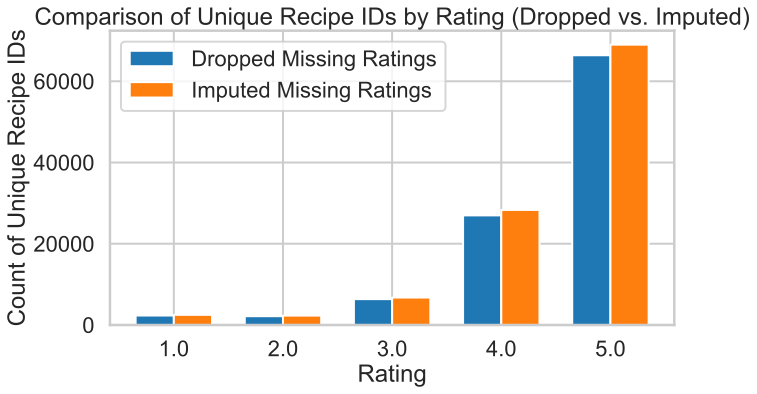

In [142]:

def get_plot(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ratings = df['rating'].values
    
    # Extract the counts for dropped and imputed datasets
    dropped_counts = df['drop_missing'].values
    imputed_counts = df['random_missing'].values
    
    # Set the x-axis positions for the bars
    bar_width = 0.35
    x = np.arange(len(ratings))
    
    # Plot bars
    ax.bar(x - bar_width/2, dropped_counts, bar_width, label='Dropped Missing Ratings')
    ax.bar(x + bar_width/2, imputed_counts, bar_width, label='Imputed Missing Ratings')
    
    # Set x-axis ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(ratings)
    
    # Set labels and title
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count of Unique Recipe IDs')
    ax.set_title('Comparison of Unique Recipe IDs by Rating (Dropped vs. Imputed)')
    
    # Add legend
    ax.legend()
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


get_plot(combine_df)

Permutation test for rating and recipe_id,  prove MCAR


In [143]:
rating_vs_step = recipes_df[['n_steps', 'rating']]
rating_vs_step

n_steps  rating
0            10     4.0
1            12     5.0
2             6     5.0
...         ...     ...
234425        5     1.0
234426        5     5.0
234427        5     NaN

[234428 rows x 2 columns]

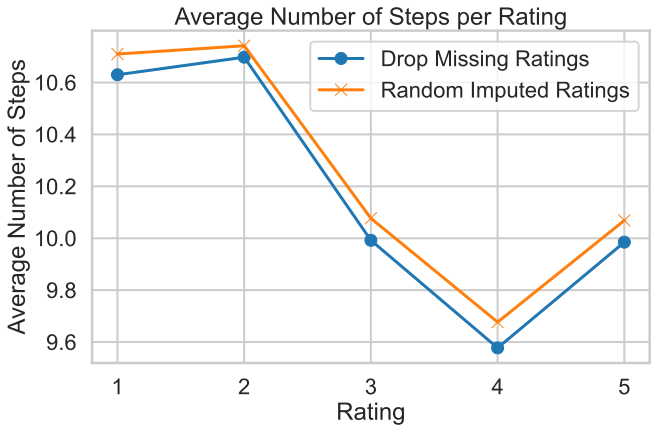

In [144]:
# Calculate the average number of steps per rating for the dataset with dropped missing ratings
drop_rating_step = rating_vs_step.dropna()
prop_drop_rating_step = drop_rating_step.groupby('rating')['n_steps'].mean()

# Calculate the average number of steps per rating for the dataset with randomly imputed ratings
random_rating_step = rating_vs_step.copy()
random_rating_step['rating'] = prob_impute(rating_vs_step['rating'])
prop_random_rating_step = random_rating_step.groupby('rating')['n_steps'].mean()

# Ensure the indices (ratings) are sorted for consistent plotting
prop_drop_rating_step = prop_drop_rating_step.sort_index()
prop_random_rating_step = prop_random_rating_step.sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(prop_drop_rating_step.index, prop_drop_rating_step.values, label='Drop Missing Ratings', marker='o')
plt.plot(prop_random_rating_step.index, prop_random_rating_step.values, label='Random Imputed Ratings', marker='x')

plt.xlabel('Rating')
plt.ylabel('Average Number of Steps')
plt.title('Average Number of Steps per Rating')
plt.legend()
plt.grid(True)
plt.xticks(prop_drop_rating_step.index)  # Set x-ticks to show all rating values
plt.show()

After calling n times permutation_test_for_mar(), we notice that the p value is various each time, which provide a clear conclusion about whether the missingness of rating relative to n_steps is Missing At Random (MAR).

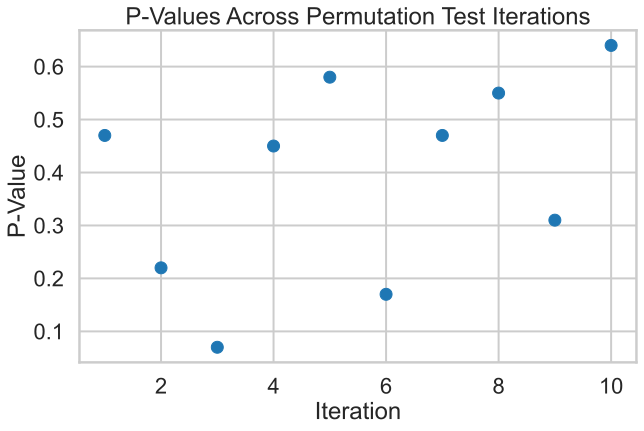

In [145]:
rating_vs_step = recipes_df[['n_steps', 'rating']]
rating_vs_step

def permutation_test_for_mar(df, n_repetion=100):

    #drop rating vs step
    drop_rating_step = df.dropna()


    #ramdon rating vs step
    random_rating_step = df.copy()
    random_rating_step['rating'] = prob_impute(df['rating'])


    drop_rating_step_var = drop_rating_step.groupby('rating')['n_steps'].var()
    random_rating_step_var = random_rating_step.groupby('rating')['n_steps'].var()

    obs_stat = np.sum(np.abs(drop_rating_step_var - random_rating_step_var))


    permuted_diffs = []
    for _ in range(n_repetion):
        # Shuffle the group_by_column values
        temp_df = df.copy()

        #drop rating vs step
        drop_rating_step = temp_df.dropna()

        #ramdon rating vs step
        random_rating_step = temp_df.copy()
        random_rating_step['rating'] = prob_impute(temp_df['rating'])

        drop_rating_step_var = drop_rating_step.groupby('rating')['n_steps'].var()
        random_rating_step_var = random_rating_step.groupby('rating')['n_steps'].var()

        test_stat = np.sum(np.abs(drop_rating_step_var - random_rating_step_var))

        permuted_diffs.append(test_stat)

    p_value = np.mean([diff >= obs_stat for diff in permuted_diffs])
    return p_value

def mar_plot(rating_vs_step, n):
    p_value_data=[]
    for _ in range(n):
        p_val = permutation_test_for_mar(rating_vs_step)
        p_value_data.append(p_val) 

    p_value_df = pd.DataFrame({'Iteration': range(1, n + 1), 'P-Value': p_value_data})
    plt.figure(figsize=(10, 6))
    plt.plot(p_value_df['Iteration'], p_value_df['P-Value'], marker='o', linestyle='')
    plt.xlabel('Iteration')
    plt.ylabel('P-Value')
    plt.title('P-Values Across Permutation Test Iterations')
    plt.show()
    return plt.show()
    

mar_plot(rating_vs_step, 10)




## Step 4: Hypothesis Testing

Null Hypothesis: Recipes that include rare ingredient(s) have same or lower ratings than those with common ingredient(s)

Alternative Hypothesis:Recipes that include rare ingredient(s) have the  higher ratings than those with common ingredient(s)

Test statistic: mean rating for recipes with rare ingredient(s) - mean rating for recipes without rare ingredient(s)


In [146]:
rare_recipes_df

minutes  n_steps  n_ingredients  rating  has_rare_ingredient
0            40       10              9     4.0                False
1            45       12             11     5.0                False
2            40        6              9     5.0                False
...         ...      ...            ...     ...                  ...
234425       20        5              7     1.0                False
234426       20        5              7     5.0                False
234427       20        5              7     NaN                False

[234428 rows x 5 columns]

In [147]:
filter_rare_df = rare_recipes_df[['rating' ,'has_rare_ingredient']]
filter_rare_df = filter_rare_df.dropna(subset=['rating'])
filter_rare_df.isna().sum()

# Splitting the dataset into two groups: with and without rare ingredients
with_rare = filter_rare_df[filter_rare_df['has_rare_ingredient'] == True]['rating']
without_rare = filter_rare_df[filter_rare_df['has_rare_ingredient'] == False]['rating']

obs_ = filter_rare_df.groupby('has_rare_ingredient')['rating'].mean().diff().iloc[1]
# 4.718997080941058 - 4.667793921175685 =0.051203159765373485 = 0.051203159765373485

obs_stat = with_rare.mean() - without_rare.mean()



In [148]:
filter_rare_df = rare_recipes_df[['rating' ,'has_rare_ingredient']]
filter_rare_df = filter_rare_df.dropna(subset=['rating'])
filter_rare_df.isna().sum()

# with rare - without rare
obs_stat = filter_rare_df.groupby('has_rare_ingredient')['rating'].mean().diff().iloc[1]

test_stat = []
for _ in range(1000):
    shuffled_df = filter_rare_df.copy()
    shuffled_data = np.random.permutation(filter_rare_df['rating'])
    shuffled_df['shuffled_rating'] = shuffled_data

    #  with rare - without rare
    perm_stat = shuffled_df.groupby('has_rare_ingredient')['shuffled_rating'].mean().diff().iloc[1]
    test_stat.append(perm_stat)

p_value = np.mean([stat > obs_stat for stat in test_stat])
# print(f"P-value: {p_value:.6f}")
p_value

0.0

With a p-value of 0, the conclusion under traditional hypothesis testing would be that there is enough evidence to reject the null hypothesis.  
So we conclude that recipes with rare ingredients tend to have the same or higher ratings that those without.

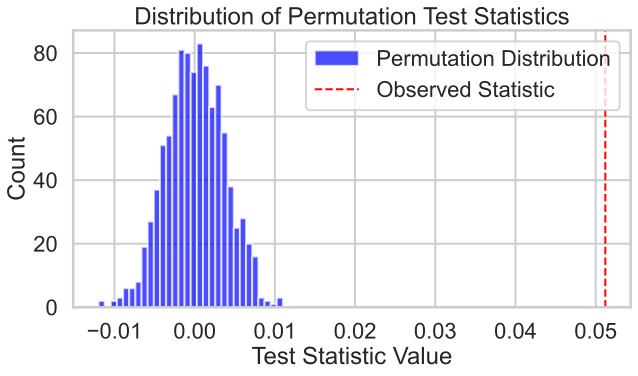

In [149]:

plt.hist(test_stat, bins=30, alpha=0.7, label='Permutation Distribution', color='blue')

# Marking the obs_stat on the plot
plt.axvline(obs_stat, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')

# Adding labels and title
plt.xlabel('Test Statistic Value')
plt.ylabel('Count')
plt.title('Distribution of Permutation Test Statistics')
plt.legend()

# Display the plot
plt.show()

## Step 5: Framing a Prediction Problem

In [150]:
rare_recipes_df = recipes_df[['minutes','n_steps', 'n_ingredients', 'rating', 'has_rare_ingredient']]
rare_recipes_df

minutes  n_steps  n_ingredients  rating  has_rare_ingredient
0            40       10              9     4.0                False
1            45       12             11     5.0                False
2            40        6              9     5.0                False
...         ...      ...            ...     ...                  ...
234425       20        5              7     1.0                False
234426       20        5              7     5.0                False
234427       20        5              7     NaN                False

[234428 rows x 5 columns]

## Step 6: Baseline Model

In [151]:
rare_recipes_df

minutes  n_steps  n_ingredients  rating  has_rare_ingredient
0            40       10              9     4.0                False
1            45       12             11     5.0                False
2            40        6              9     5.0                False
...         ...      ...            ...     ...                  ...
234425       20        5              7     1.0                False
234426       20        5              7     5.0                False
234427       20        5              7     NaN                False

[234428 rows x 5 columns]

In [152]:
model_df = rare_recipes_df.dropna(subset=['rating'])
model_df['n_steps'].mean()

9.931975951830733

In [153]:
model_df

minutes  n_steps  n_ingredients  rating  has_rare_ingredient
0            40       10              9     4.0                False
1            45       12             11     5.0                False
2            40        6              9     5.0                False
...         ...      ...            ...     ...                  ...
234424       29        9             10     1.0                False
234425       20        5              7     1.0                False
234426       20        5              7     5.0                False

[219393 rows x 5 columns]

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

model_df = recipes_df.dropna(subset=['rating'])
# model_df['n_steps'].mean()


X = model_df[['minutes', 'sugar', 'has_rare_ingredient']]
y = model_df['calories']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the column transformer
col_trans = ColumnTransformer([
    ('all-col', StandardScaler(), ['minutes', 'sugar']),
    ('ohe', OneHotEncoder(drop='first'), ['has_rare_ingredient'])
], remainder='passthrough')

# Creating the pipeline
pl = Pipeline([
    ('preprocessor', col_trans),
    ('regressor', LinearRegression())
])

# Fitting the pipeline on the training data
pl.fit(X_train, y_train)

# Predictions on the training and test data
y_train_pred = pl.predict(X_train)
y_test_pred = pl.predict(X_test)

# Calculating RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Computing R^2 score
r_squared = pl.score(X_test, y_test)

train_rmse, test_rmse, r_squared

(419.1282472709378, 435.67420994505636, 0.41696766070848146)

## Step 7: Final Model

In [155]:
fin_model_df = recipes_df.copy()

fin_model_df = recipes_df[['minutes', 'n_steps', 'n_ingredients', 'rating', 'has_rare_ingredient', 'calories', 'total_fat' ,'sugar','sodium' ,'protein','carbs','sat_fat']]
fin_model_df = fin_model_df.dropna(subset=['rating'])

fin_model_df


minutes  n_steps  n_ingredients  rating  ...  sodium  protein  carbs  \
0            40       10              9     4.0  ...     3.0      3.0    6.0   
1            45       12             11     5.0  ...    22.0     13.0   26.0   
2            40        6              9     5.0  ...    32.0     22.0    3.0   
...         ...      ...            ...     ...  ...     ...      ...    ...   
234424       29        9             10     1.0  ...    11.0      7.0    9.0   
234425       20        5              7     1.0  ...     4.0      4.0    6.0   
234426       20        5              7     5.0  ...     4.0      4.0    6.0   

        sat_fat  
0          19.0  
1          51.0  
2          36.0  
...         ...  
234424     21.0  
234425     11.0  
234426     11.0  

[219393 rows x 12 columns]

Convert minutes to categorical [short, mid, long]

In [156]:
def carbs_prop(df):
    bins = [0, 4, 8, float('inf')]
    labels = ['low', 'mid', 'high']
    new_df = df.copy()
    new_df['carb_prop'] = pd.cut(df['carbs'], bins=bins, labels=labels, right= False)
    return new_df

fin_model_df = carbs_prop(fin_model_df)
fin_model_df


minutes  n_steps  n_ingredients  rating  ...  protein  carbs  sat_fat  \
0            40       10              9     4.0  ...      3.0    6.0     19.0   
1            45       12             11     5.0  ...     13.0   26.0     51.0   
2            40        6              9     5.0  ...     22.0    3.0     36.0   
...         ...      ...            ...     ...  ...      ...    ...      ...   
234424       29        9             10     1.0  ...      7.0    9.0     21.0   
234425       20        5              7     1.0  ...      4.0    6.0     11.0   
234426       20        5              7     5.0  ...      4.0    6.0     11.0   

        carb_prop  
0             mid  
1            high  
2             low  
...           ...  
234424       high  
234425        mid  
234426        mid  

[219393 rows x 13 columns]

Create time spend columns: minutes / steps

In [157]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Binarizer, FunctionTransformer, OneHotEncoder


X = fin_model_df[['minutes', 'sugar', 'has_rare_ingredient','n_steps' ,'carb_prop','protein']]

y = fin_model_df['calories']

X_train, X_test, y_trian, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


col_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['has_rare_ingredient','carb_prop']),
    ('all-col', StandardScaler(), ['minutes', 'sugar', 'protein']),
    ('binarize-step', Binarizer(threshold=9), ['n_steps'])
],remainder='passthrough')

# Creating the pipeline
pl = Pipeline([
    ('preprocessor', col_trans),
    ('regressor', LinearRegression())
])

# Fitting the pipeline on the training data
pl.fit(X_train, y_train)

# Predictions on the training and test data
y_train_pred = pl.predict(X_train)
y_test_pred = pl.predict(X_test)

# Calculating RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Computing R^2 score
r_squared = pl.score(X_test, y_test)

train_rmse, test_rmse, r_squared

(290.8383864443081, 312.32751420182524, 0.70036714710409)

In [158]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


In [159]:
pl = Pipeline([('poly', PolynomialFeatures(2)), ('lin-reg', LinearRegression())])
pl = make_pipeline(PolynomialFeatures(2), LinearRegression())
train_errs = []
test_errs = []

X_train, X_test, y_trian, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for d in range(1, 6):
    col_trans = ColumnTransformer([
        ('ohe', OneHotEncoder(), ['has_rare_ingredient','carb_prop']),
        ('all-col', StandardScaler(), ['minutes', 'sugar', 'protein']),
        ('binarize-step', Binarizer(threshold=9), ['n_steps'])
    ],remainder='passthrough')

    # Creating the pipeline
    pl = Pipeline([
        ('preprocessor', col_trans),
        ('poly', PolynomialFeatures(d)),
        ('regressor', LinearRegression())
    ])
    pl.fit(X_train, y_train)
    train_errs.append(mean_squared_error(y_train, pl.predict(X_train), squared=False))
    test_errs.append(mean_squared_error(y_test, pl.predict(X_test), squared=False))

errs = pd.DataFrame({'Train Error': train_errs, 'Test Error': test_errs})

In [160]:
fig = px.line(errs)
fig.update_layout(showlegend=True, xaxis_title='Polynomial Degree', yaxis_title='RMSE')
# fig.write_html('hyperparameter.html', include_plotlyjs='cdn')

## Step 8: Fairness Analysis

Null Hypothesis: Our model is fair. Its precision for recipes including rare ingredients and recipes not including rare ingredients are roughly the same, and any differences are due to random chance.

Alternative Hypothesis: Our model is unfair. Its precision for recipes including rare ingredients than its precision for recipes not including rare ingredients.

In [161]:
from sklearn.linear_model import LogisticRegression


In [162]:
fin_model_df['has_rare_ingredient']
rare_gourp = fin_model_df.query('has_rare_ingredient ==True')
common_gourp = fin_model_df.query('has_rare_ingredient ==False')
common_gourp

minutes  n_steps  n_ingredients  rating  ...  protein  carbs  sat_fat  \
0            40       10              9     4.0  ...      3.0    6.0     19.0   
1            45       12             11     5.0  ...     13.0   26.0     51.0   
2            40        6              9     5.0  ...     22.0    3.0     36.0   
...         ...      ...            ...     ...  ...      ...    ...      ...   
234424       29        9             10     1.0  ...      7.0    9.0     21.0   
234425       20        5              7     1.0  ...      4.0    6.0     11.0   
234426       20        5              7     5.0  ...      4.0    6.0     11.0   

        carb_prop  
0             mid  
1            high  
2             low  
...           ...  
234424       high  
234425        mid  
234426        mid  

[167664 rows x 13 columns]

In [163]:

X_rare = rare_gourp[['minutes', 'sugar','n_steps' ,'carb_prop','protein']]
y_rare = rare_gourp['calories']


X_comm = common_gourp[['minutes', 'sugar','n_steps' ,'carb_prop','protein']]
y_comm = common_gourp['calories']

X_train_ra, X_test_ra, y_train_ra, y_test_ra = train_test_split(X_rare, y_rare, test_size=0.2, random_state=42)
X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(X_comm, y_comm, test_size=0.2, random_state=42)


col_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['carb_prop']),
    ('all-col', StandardScaler(), ['minutes', 'sugar', 'protein']),
    ('binarize-step', Binarizer(threshold=9), ['n_steps'])
],remainder='passthrough')

# Creating the pipeline
pl = Pipeline([
    ('preprocessor', col_trans),
    ('regressor', LinearRegression())
])

# Fitting the pipeline on the training data

pl.fit(X_train_ra, y_train_ra)
pl.fit(X_train_co, y_train_co)

test_ra_pred = mean_squared_error(y_test_ra, pl.predict(X_test_ra), squared=False)
test_co_pred = mean_squared_error(y_test_co, pl.predict(X_test_co), squared=False)

obs_stat = test_ra_pred - test_co_pred


permu_stat = []

n =100
for _ in range(n):
    fin_model_df['shuffle_rare'] = np.random.permutation(fin_model_df['has_rare_ingredient'])
    rare_gourp = fin_model_df.query('shuffle_rare ==True')
    common_gourp = fin_model_df.query('shuffle_rare ==False')

    X_rare = rare_gourp[['minutes', 'sugar','n_steps' ,'carb_prop','protein']]
    y_rare = rare_gourp['calories']


    X_comm = common_gourp[['minutes', 'sugar','n_steps' ,'carb_prop','protein']]
    y_comm = common_gourp['calories']

    X_train_ra, X_test_ra, y_train_ra, y_test_ra = train_test_split(X_rare, y_rare, test_size=0.2, random_state=42)
    X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(X_comm, y_comm, test_size=0.2, random_state=42)


    col_trans = ColumnTransformer([
        ('ohe', OneHotEncoder(), ['carb_prop']),
        ('all-col', StandardScaler(), ['minutes', 'sugar', 'protein']),
        ('binarize-step', Binarizer(threshold=9), ['n_steps'])
    ],remainder='passthrough')

    # Creating the pipeline
    pl = Pipeline([
        ('preprocessor', col_trans),
        ('regressor', LinearRegression())
    ])

    # Fitting the pipeline on the training data

    pl.fit(X_train_ra, y_train_ra)
    pl.fit(X_train_co, y_train_co)

    test_ra_pred = mean_squared_error(y_test_ra, pl.predict(X_test_ra), squared=False)
    test_co_pred = mean_squared_error(y_test_co, pl.predict(X_test_co), squared=False)

    test_stat = test_ra_pred - test_co_pred
    permu_stat.append(test_stat)


# Calculate p-value
p_value = np.mean(np.array(permu_stat) >= obs_stat)

# Print p-value and interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The model may be unfair.")
else:
    print("Fail to reject the null hypothesis: The model appears to be fair.")

Fail to reject the null hypothesis: The model appears to be fair.


In [164]:
p_value

0.61